# My DUSTED (ish) Pipeline
You have to start by defining the dataset info. 
Currently it only works with librispeech (oops)
1. Loading in the Dataset

In [80]:
from pathlib import Path

name = "librispeech-dev-clean"
in_dir = Path("data/dev-clean")
align_dir = Path("data/alignments/dev-clean")
feat_dir = Path("features")
audio_ext = ".flac" 

In [81]:
from encode import sample_files
from utils.features import DataSet

dataset = DataSet(
    name, in_dir, align_dir, feat_dir, audio_ext 
)

# Choose how many files you want to sample. (-1 = all)
sample_size = 20
sampled_paths = sample_files(dataset, sample_size)
print(len(sampled_paths))

500


In [3]:
# If you want to be fun, check the ladys:
sampled_paths = [
    Path("data/dev-clean/174/50561/174-50561-0005.flac"), 
    Path("data/dev-clean/3081/166546/3081-166546-0058.flac"), 
    Path("data/dev-clean/84/121550/84-121550-0026.flac"),
    Path("data/dev-clean/174/50561/174-50561-0008.flac")
]

In [104]:
import numpy as np
from utils.features import WordUnit

def load_word(word_path, word_id, align_df):
    # id = in dataset
    # index = in file
    parts = word_path.stem.split("_")
    word_df = align_df[align_df["filename"]==parts[0]]
    word_df = word_df[word_df["word_id"]==int(parts[1])]

    units = np.load(word_path)

    if not isinstance(word_df["text"], str):
        true_word = "_"
    else:
        true_word = word_df["text"].iloc[0]

    word = WordUnit(
        id=word_id,
        filename=parts[0], 
        index=parts[1],
        true_word=true_word, 
        boundaries=[word_df["word_start"].iloc[0], word_df["word_end"].iloc[0]]
    )
    word.update_encoding(units)
    return word


In [105]:
# If you don't want to recalculate distances
import numpy as np
import pandas as pd
from tqdm import tqdm
# from distance import load_word

out_dir_hub = Path(f"output/hubert/{sample_size}")
out_dir_dust = Path(f"output/dusted/{sample_size}")

dist_mat_hub = np.load(out_dir_hub / "dist_mat.npy")
dist_mat_dust = np.load(out_dir_dust / "dist_mat.npy")

hub_words_csv = pd.read_csv(out_dir_hub / "words.csv")
dust_words_csv = pd.read_csv(out_dir_dust / "words.csv")

align_df = pd.read_csv(dataset.align_dir / "alignments.csv")

hubert_words = []
for index, row in tqdm(hub_words_csv.iterrows(), desc="Get Hubert Words"):
    id = row['id']
    filename = row['filename']
    index = row['index']

    filename_parts = filename.split("-")
    word_path = dataset.feat_dir / "hubert_units" / filename_parts[0] / filename_parts[1] / f"{filename}_{index}.npy" 
    hub_word = load_word(word_path, id, align_df)
    hubert_words.append(hub_word)




In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def get_words_and_dist_mat(dataset, model, out_dir, sample_size):

    out_dir = Path(f"output/{model}/{sample_size}")
    dist_mat = np.load(out_dir / "dist_mat.npy")
    words_csv = pd.read_csv(out_dir / "words.csv")

    align_df = pd.read_csv(dataset.align_dir / "alignments.csv")

    words = []
    for index, row in tqdm(words_csv.iterrows(), desc=f"Getting {model} words"):
        id = row['id']
        filename = row['filename']
        index = row['index']

        filename_parts = filename.split("-")
        word_path = dataset.feat_dir / f"{model}_units" / filename_parts[0] / filename_parts[1] / f"{filename}_{index}.npy" 
        word = load_word(word_path, id, align_df)
        words.append(word)
    
    return words, dist_mat
    

# My DUSTED (ish) Pipeline
You have to start by defining the dataset info. 
Currently it only works with librispeech (oops)
1. Loading in the Dataset

In [ ]:
from pathlib import Path

name = "librispeech-dev-clean"
in_dir = Path("data/dev-clean")
align_dir = Path("data/alignments/dev-clean")
feat_dir = Path("features")
audio_ext = ".flac" 

In [ ]:
from encode import sample_files
from utils.features import DataSet

dataset = DataSet(
    name, in_dir, align_dir, feat_dir, audio_ext 
)

# Choose how many files you want to sample. (-1 = all)
sample_size = 500
sampled_paths = sample_files(dataset, sample_size)
print(len(sampled_paths))

500


In [ ]:
# If you want to be fun, check the ladys:
sampled_paths = [
    Path("data/dev-clean/174/50561/174-50561-0005.flac"), 
    Path("data/dev-clean/3081/166546/3081-166546-0058.flac"), 
    Path("data/dev-clean/84/121550/84-121550-0026.flac"),
    Path("data/dev-clean/174/50561/174-50561-0008.flac")
]

In [ ]:
from distance import load_units_from_paths
from joblib import Parallel, delayed

# If the units are already computed and saved in the feat_dir you can simply load them in: 
results = Parallel(n_jobs=2)([
    delayed(load_units_from_paths)(dataset, sampled_paths, 0.2)  
])
hubert_words, dusted_words = results[0]

Loading Units: 100%|██████████| 500/500 [02:24<00:00,  3.45it/s]


In [ ]:
from encode import get_units
from joblib import Parallel, delayed

# Otherwise you have to first encode the waveforms to get the units.
# Encoding is done using Benji's hubert and kmeans models.
results = Parallel(n_jobs=2)([
    delayed(get_units)(dataset, sampled_paths, 0.2)  
])
hubert_words, dusted_words = results[0]

Using cache found in /home/danel/.cache/torch/hub/bshall_hubert_main
Using cache found in /home/danel/.cache/torch/hub/bshall_dusted_main
Using cache found in /home/danel/.cache/torch/hub/bshall_dusted_main
Using cache found in /home/danel/.cache/torch/hub/bshall_hubert_main
Getting units: 100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


The next is a little sanity check for the number of word types and their occurences in our sampled data. 
The true words are also stored in an array for later understanding and visualisation.

In [ ]:
from collections import Counter
import pandas as pd
import ace_tools_open as tools

num_words = len(hubert_words)
true_words = []

for w in range(num_words): 

    if not isinstance(hubert_words[w].true_word, str):
        true_words.append("_")
    else:
        true_words.append(hubert_words[w].true_word)
        

counts = Counter(true_words)

word_counts_df = pd.DataFrame(counts.items(), columns=["Word", "Count"])
word_counts_df = word_counts_df.sort_values(by="Count", ascending=False)
tools.display_dataframe_to_user(name="Sorted Word Counts", dataframe=word_counts_df)

Sorted Word Counts


2. Calculating the distances between words

In [ ]:
from distance import calculate_distance

# Need to specify where the dist matrices are stored -> could maybe look at a different naming convention
out_dir_dusted = Path(f"output/dusted/{sample_size}")
out_dir_hubert = Path(f"output/hubert/{sample_size}")

# If calculate_distance is called with only the words, it does not save the matrices
dist_mat_dusted = calculate_distance(dusted_words, out_dir_dusted)
print()
dist_mat_hubert = calculate_distance(hubert_words, out_dir_hubert)

Calculating Distances: 100%|██████████| 11876/11876 [02:18<00:00, 85.55it/s]  


[[0.         1.         1.         0.88235294 0.85714286]
 [1.         0.         0.85714286 1.         1.        ]
 [1.         0.85714286 0.         1.         0.875     ]
 [0.88235294 1.         1.         0.         1.        ]
 [0.85714286 1.         0.875      1.         0.        ]]



Calculating Distances: 100%|██████████| 11876/11876 [03:38<00:00, 54.35it/s] 


[[0.         1.         1.         0.89473684 0.9375    ]
 [1.         0.         0.95833333 1.         1.        ]
 [1.         0.95833333 0.         0.97368421 0.95833333]
 [0.89473684 1.         0.97368421 0.         0.97368421]
 [0.9375     1.         0.95833333 0.97368421 0.        ]]


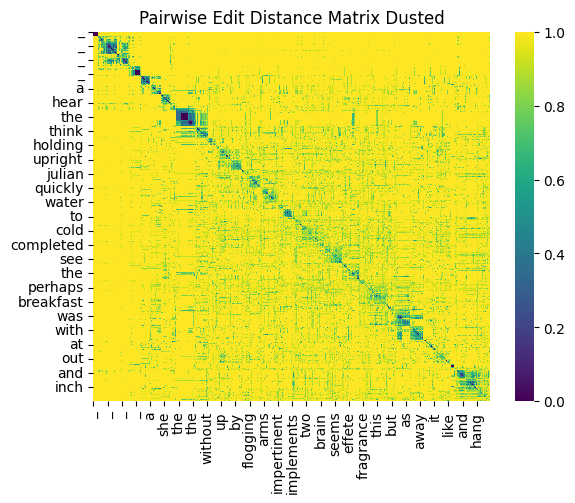

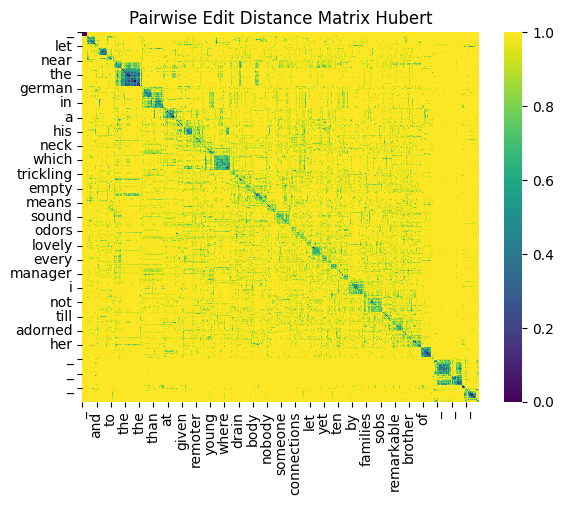

In [ ]:
from eval import pairwise_edit_dist_mat

# Visualise the distances
pairwise_edit_dist_mat(dist_mat_dusted, "Pairwise Edit Distance Matrix Dusted", true_words)
pairwise_edit_dist_mat(dist_mat_hubert, "Pairwise Edit Distance Matrix Hubert", true_words)

In [ ]:
from cluster import cluster, get_word_clusters

# Get the int_clusters for each of the matrices
dust_clusters = cluster(dist_mat_dusted, 0.3)
hub_clusters = cluster(dist_mat_hubert, 0.3)

# Convert these to word clusters
dust_word_clusters = get_word_clusters(dust_clusters, dusted_words)
hub_word_clusters = get_word_clusters(hub_clusters, hubert_words)

In [ ]:
from eval import ned

# Compute the ned for my dusted and hubert clusters - atm my NED is computed only using clusters with > 1 words
ned_dusted = ned(dust_word_clusters, print_inpure=False)
ned_hubert = ned(hub_word_clusters, print_inpure=False)

print(f"DUSTED NED: {ned_dusted}")
print(f"HuBERT NED: {ned_hubert}")

DUSTED NED: 2.939590978781798
HuBERT NED: 0.6645162933222419


Wrote words to output/dusted/500/words_500.csv
Wrote words to output/hubert/500/words_500.csv


In [ ]:
from cluster import get_best_clusters

ned_dusted, duplicate_count_dusted, dust_word_clusters = get_best_clusters(dust_word_clusters, ned_dusted, max_iter=2)
print()
ned_hubert, duplicate_counts_hubert, hub_word_clusters = get_best_clusters(hub_word_clusters, ned_hubert, max_iter=2)

Iteration 0: NED: 2.939591
Iteration 1: NED: 0.385485
Iteration 2: NED: 0.269292
Best NED: 0.269292, Best Duplicates: 2075

Iteration 0: NED: 0.664516
Iteration 1: NED: 0.176160
Iteration 2: NED: 0.152630
Best NED: 0.152630, Best Duplicates: 3719


In [ ]:
from eval import words_from_word_units, clusters_purity
            
dust_just_words_clusters = words_from_word_units(dust_word_clusters)
inpurity, total = clusters_purity(dust_just_words_clusters)
print(f"{total} Dusted Clusters with inpurity: {round(inpurity*100, 3)}%")

hub_just_words_clusters = words_from_word_units(hub_word_clusters)
inpurity, total = clusters_purity(hub_just_words_clusters)
print(f"{total} Hubert Clusters with inpurity: {round(inpurity*100, 3)}%")

5029 Dusted Clusters with inpurity: 52.754%
6483 Hubert Clusters with inpurity: 57.396%


In [ ]:
from eval import calculate_duplicate_clusters

cluster_counts_dusted, duplicate_counts_dusted = calculate_duplicate_clusters(dust_word_clusters, print_clusters=True)
print()
cluster_counts_hubert, duplicate_counts_hubert = calculate_duplicate_clusters(hub_word_clusters)

Total duplicate clusters (considering word frequency): 2075
Duplicate clusters and their counts:
{'_': 1}: 87 times
{'_': 7}: 5 times
{'passions': 1}: 2 times
{'received': 1}: 2 times
{'egypt': 1}: 3 times
{'arms': 1}: 4 times
{'lived': 1}: 2 times
{'so': 1}: 3 times
{'a': 2}: 8 times
{'comfortably': 1}: 2 times
{'great': 2}: 2 times
{'_': 4}: 9 times
{'and': 3, 'in': 1}: 2 times
{'skin': 1}: 2 times
{'color': 1, 'collar': 1}: 2 times
{'early': 1}: 2 times
{'joyous': 1}: 2 times
{'thousand': 1}: 3 times
{'street': 1}: 5 times
{'whose': 1}: 4 times
{'generous': 1}: 2 times
{'_': 16}: 3 times
{'violent': 1}: 2 times
{'disturb': 1}: 2 times
{'hardly': 1}: 2 times
{'had': 1}: 11 times
{'news': 1}: 2 times
{'consequences': 1}: 2 times
{'strolled': 1}: 2 times
{'completely': 1}: 4 times
{'eyes': 1}: 2 times
{'remembered': 1}: 3 times
{'sense': 1}: 2 times
{'wonderful': 1}: 2 times
{'ours': 1}: 3 times
{'that': 2}: 6 times
{'captain': 1}: 2 times
{'mister': 1}: 3 times
{'well': 3}: 2 times
{'

In [ ]:
def display_words(word_units):

    num_words = len(word_units)
    true_words = []

    for w in range(num_words): 

        if not isinstance(word_units[w].true_word, str):
            true_words.append("_")
        else:
            true_words.append(word_units[w].true_word)
            

    counts = Counter(true_words)

    word_counts_df = pd.DataFrame(counts.items(), columns=["Word", "Count"])
    word_counts_df = word_counts_df.sort_values(by="Count", ascending=False)
    tools.display_dataframe_to_user(name="Sorted Word Counts", dataframe=word_counts_df)

In [ ]:
from encode import sample_files

query_path = sample_files(dataset, sample_size=1)

from distance import load_units

query_hub_words, query_dusted_words = load_units(dataset, query_path, 0.2)
query_hub_sentence = " ".join([w.true_word for w in query_hub_words])

from cluster import get_distance_to_centroids, get_cluster_centroids

hub_centroids = get_cluster_centroids(hub_word_clusters)
query_hub_words = get_distance_to_centroids([query_hub_words], hub_centroids)

import editdistance
import statistics

predictions = []
query_distances = []
for word in query_hub_words:
    prediction = hub_centroids[word.cluster_id].true_word
    query_distances.append(editdistance.eval(word.true_word, prediction)/max(len(word.true_word), len(prediction)))
    predictions.append(prediction)

prediction_sentence = " ".join(predictions)
print(f"NED for query: {statistics.mean(query_distances)}")
print(query_hub_sentence)
print(prediction_sentence)

Loading Units: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


NED for query: 0.15288888888888888
exciting aware no that him think had _ happened the to adventure that time was _ most ever this he had was but he to
decided where no the him things had _ captain the to inch that time was _ most ever this he had was but he to


In [58]:
from distance import load_units_from_paths
from joblib import Parallel, delayed

# If the units are already computed and saved in the feat_dir you can simply load them in: 
results = Parallel(n_jobs=2)([
    delayed(load_units_from_paths)(dataset, sampled_paths, 0.2)  
])
hubert_words, dusted_words = results[0]

Loading Units: 100%|██████████| 500/500 [02:24<00:00,  3.45it/s]


In [60]:
from encode import get_units
from joblib import Parallel, delayed

# Otherwise you have to first encode the waveforms to get the units.
# Encoding is done using Benji's hubert and kmeans models.
results = Parallel(n_jobs=2)([
    delayed(get_units)(dataset, sampled_paths, 0.2)  
])
hubert_words, dusted_words = results[0]

Using cache found in /home/danel/.cache/torch/hub/bshall_hubert_main
Using cache found in /home/danel/.cache/torch/hub/bshall_dusted_main
Using cache found in /home/danel/.cache/torch/hub/bshall_dusted_main
Using cache found in /home/danel/.cache/torch/hub/bshall_hubert_main
Getting units: 100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


The next is a little sanity check for the number of word types and their occurences in our sampled data. 
The true words are also stored in an array for later understanding and visualisation.

In [59]:
from collections import Counter
import pandas as pd
import ace_tools_open as tools

num_words = len(hubert_words)
true_words = []

for w in range(num_words): 

    if not isinstance(hubert_words[w].true_word, str):
        true_words.append("_")
    else:
        true_words.append(hubert_words[w].true_word)
        

counts = Counter(true_words)

word_counts_df = pd.DataFrame(counts.items(), columns=["Word", "Count"])
word_counts_df = word_counts_df.sort_values(by="Count", ascending=False)
tools.display_dataframe_to_user(name="Sorted Word Counts", dataframe=word_counts_df)

Sorted Word Counts


2. Calculating the distances between words

In [60]:
from distance import calculate_distance

# Need to specify where the dist matrices are stored -> could maybe look at a different naming convention
out_dir_dusted = Path(f"output/dusted/{sample_size}")
out_dir_hubert = Path(f"output/hubert/{sample_size}")

# If calculate_distance is called with only the words, it does not save the matrices
dist_mat_dusted = calculate_distance(dusted_words, out_dir_dusted)
print()
dist_mat_hubert = calculate_distance(hubert_words, out_dir_hubert)

Calculating Distances: 100%|██████████| 11876/11876 [02:18<00:00, 85.55it/s]  


[[0.         1.         1.         0.88235294 0.85714286]
 [1.         0.         0.85714286 1.         1.        ]
 [1.         0.85714286 0.         1.         0.875     ]
 [0.88235294 1.         1.         0.         1.        ]
 [0.85714286 1.         0.875      1.         0.        ]]



Calculating Distances: 100%|██████████| 11876/11876 [03:38<00:00, 54.35it/s] 


[[0.         1.         1.         0.89473684 0.9375    ]
 [1.         0.         0.95833333 1.         1.        ]
 [1.         0.95833333 0.         0.97368421 0.95833333]
 [0.89473684 1.         0.97368421 0.         0.97368421]
 [0.9375     1.         0.95833333 0.97368421 0.        ]]


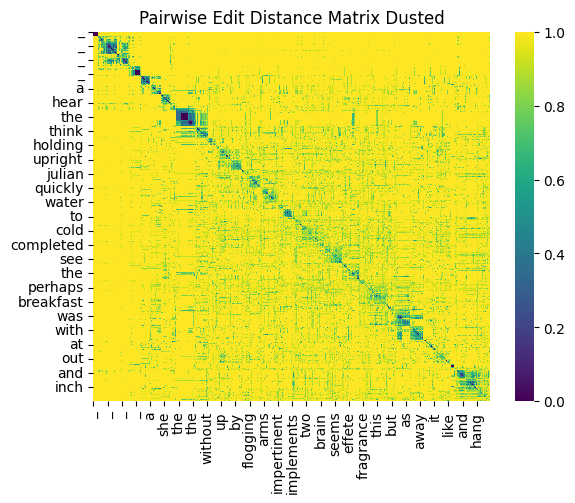

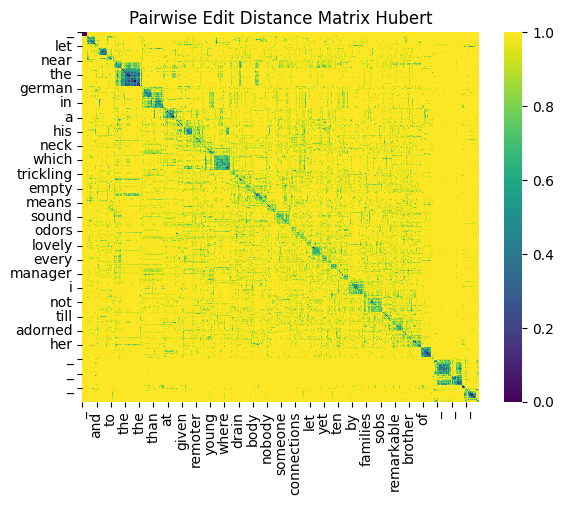

In [61]:
from eval import pairwise_edit_dist_mat

# Visualise the distances
pairwise_edit_dist_mat(dist_mat_dusted, "Pairwise Edit Distance Matrix Dusted", true_words)
pairwise_edit_dist_mat(dist_mat_hubert, "Pairwise Edit Distance Matrix Hubert", true_words)

In [65]:
from cluster import cluster, get_word_clusters

# Get the int_clusters for each of the matrices
dust_clusters = cluster(dist_mat_dusted, 0.3)
hub_clusters = cluster(dist_mat_hubert, 0.3)

# Convert these to word clusters
dust_word_clusters = get_word_clusters(dust_clusters, dusted_words)
hub_word_clusters = get_word_clusters(hub_clusters, hubert_words)

In [66]:
from eval import ned

# Compute the ned for my dusted and hubert clusters - atm my NED is computed only using clusters with > 1 words
ned_dusted = ned(dust_word_clusters, print_inpure=False)
ned_hubert = ned(hub_word_clusters, print_inpure=False)

print(f"DUSTED NED: {ned_dusted}")
print(f"HuBERT NED: {ned_hubert}")

DUSTED NED: 2.939590978781798
HuBERT NED: 0.6645162933222419


In [67]:
from cluster import get_best_clusters

ned_dusted, duplicate_count_dusted, dust_word_clusters = get_best_clusters(dust_word_clusters, ned_dusted, max_iter=2)
print()
ned_hubert, duplicate_counts_hubert, hub_word_clusters = get_best_clusters(hub_word_clusters, ned_hubert, max_iter=2)

Iteration 0: NED: 2.939591
Iteration 1: NED: 0.385485
Iteration 2: NED: 0.269292
Best NED: 0.269292, Best Duplicates: 2075

Iteration 0: NED: 0.664516
Iteration 1: NED: 0.176160
Iteration 2: NED: 0.152630
Best NED: 0.152630, Best Duplicates: 3719


In [ ]:
from utils.features import store_words

store_words(dust_word_clusters, out_dir_dusted)
store_words(hub_word_clusters, out_dir_hubert)

In [74]:
from eval import words_from_word_units, clusters_purity
            
dust_just_words_clusters = words_from_word_units(dust_word_clusters)
inpurity, total = clusters_purity(dust_just_words_clusters)
print(f"{total} Dusted Clusters with inpurity: {round(inpurity*100, 3)}%")

hub_just_words_clusters = words_from_word_units(hub_word_clusters)
inpurity, total = clusters_purity(hub_just_words_clusters)
print(f"{total} Hubert Clusters with inpurity: {round(inpurity*100, 3)}%")

5029 Dusted Clusters with inpurity: 52.754%
6483 Hubert Clusters with inpurity: 57.396%


In [75]:
from eval import calculate_duplicate_clusters

cluster_counts_dusted, duplicate_counts_dusted = calculate_duplicate_clusters(dust_word_clusters, print_clusters=True)
print()
cluster_counts_hubert, duplicate_counts_hubert = calculate_duplicate_clusters(hub_word_clusters)

Total duplicate clusters (considering word frequency): 2075
Duplicate clusters and their counts:
{'_': 1}: 87 times
{'_': 7}: 5 times
{'passions': 1}: 2 times
{'received': 1}: 2 times
{'egypt': 1}: 3 times
{'arms': 1}: 4 times
{'lived': 1}: 2 times
{'so': 1}: 3 times
{'a': 2}: 8 times
{'comfortably': 1}: 2 times
{'great': 2}: 2 times
{'_': 4}: 9 times
{'and': 3, 'in': 1}: 2 times
{'skin': 1}: 2 times
{'color': 1, 'collar': 1}: 2 times
{'early': 1}: 2 times
{'joyous': 1}: 2 times
{'thousand': 1}: 3 times
{'street': 1}: 5 times
{'whose': 1}: 4 times
{'generous': 1}: 2 times
{'_': 16}: 3 times
{'violent': 1}: 2 times
{'disturb': 1}: 2 times
{'hardly': 1}: 2 times
{'had': 1}: 11 times
{'news': 1}: 2 times
{'consequences': 1}: 2 times
{'strolled': 1}: 2 times
{'completely': 1}: 4 times
{'eyes': 1}: 2 times
{'remembered': 1}: 3 times
{'sense': 1}: 2 times
{'wonderful': 1}: 2 times
{'ours': 1}: 3 times
{'that': 2}: 6 times
{'captain': 1}: 2 times
{'mister': 1}: 3 times
{'well': 3}: 2 times
{'

In [76]:
def display_words(word_units):

    num_words = len(word_units)
    true_words = []

    for w in range(num_words): 

        if not isinstance(word_units[w].true_word, str):
            true_words.append("_")
        else:
            true_words.append(word_units[w].true_word)
            

    counts = Counter(true_words)

    word_counts_df = pd.DataFrame(counts.items(), columns=["Word", "Count"])
    word_counts_df = word_counts_df.sort_values(by="Count", ascending=False)
    tools.display_dataframe_to_user(name="Sorted Word Counts", dataframe=word_counts_df)

In [78]:
from encode import sample_files

query_path = sample_files(dataset, sample_size=1)

from distance import load_units

query_hub_words, query_dusted_words = load_units(dataset, query_path, 0.2)
query_hub_sentence = " ".join([w.true_word for w in query_hub_words])

from cluster import get_distance_to_centroids, get_cluster_centroids

hub_centroids = get_cluster_centroids(hub_word_clusters)
query_hub_words = get_distance_to_centroids([query_hub_words], hub_centroids)

import editdistance
import statistics

predictions = []
query_distances = []
for word in query_hub_words:
    prediction = hub_centroids[word.cluster_id].true_word
    query_distances.append(editdistance.eval(word.true_word, prediction)/max(len(word.true_word), len(prediction)))
    predictions.append(prediction)

prediction_sentence = " ".join(predictions)
print(f"NED for query: {statistics.mean(query_distances)}")
print(query_hub_sentence)
print(prediction_sentence)

Loading Units: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


NED for query: 0.15288888888888888
exciting aware no that him think had _ happened the to adventure that time was _ most ever this he had was but he to
decided where no the him things had _ captain the to inch that time was _ most ever this he had was but he to
